<a href="https://colab.research.google.com/github/Deepthi-cloud/Machine-Learning-Capstone-Project-/blob/master/Aerial_Cactus_identification_Final_V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [0]:
import os,cv2
import json
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from tqdm import tqdm, tqdm_notebook
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint



Using TensorFlow backend.


In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
PATH = "../input"
!ls {PATH}

sample_submission.csv  test  train  train.csv


In [0]:
train_dir = "../input/train/train"
test_dir = "../input/test/test"

In [0]:
df_train = pd.read_csv(f'{PATH}/train.csv',low_memory=False)
df_test = pd.read_csv(f'{PATH}/sample_submission.csv',low_memory=False)
df_train.has_cactus= df_train.has_cactus.astype(str)

In [0]:
print('Shape of Training data: {}'.format(df_train.shape))
print('Features: {}'.format(df_train.columns))

Shape of Training data: (17500, 2)
Features: Index(['id', 'has_cactus'], dtype='object')


In [0]:
df_train.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


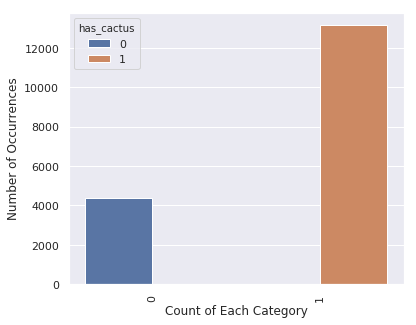

In [0]:
plt.figure(figsize = (6,5))
sns.set(style="darkgrid")
ax = sns.countplot(x = 'has_cactus',hue='has_cactus',data = df_train)
plt.xticks(rotation='vertical')
plt.xlabel('Count of Each Category', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

In [0]:
df_train['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

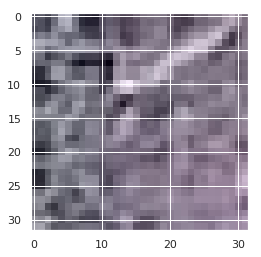

In [0]:
im = cv2.imread("../input/train/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg")
plt.imshow(im)

In [0]:
train_datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Data Augmentation: https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced

In [0]:
valid_datagen = ImageDataGenerator(rescale=1/.255)

In [0]:
batch_size= 32

In [0]:
train_generator = train_datagen.flow_from_dataframe(df_train[:15000], directory=train_dir, x_col='id', y_col='has_cactus', 
                    target_size=(150, 150), color_mode='rgb', classes=None, class_mode='binary',
                    batch_size=batch_size, 
                    shuffle=True, seed=None, 
                    save_to_dir=None, save_prefix='', save_format='png', 
                    subset=None, interpolation='nearest', drop_duplicates=True)

Found 15000 validated image filenames belonging to 2 classes.


In [0]:
valid_generator = valid_datagen.flow_from_dataframe(df_train[15000:], directory=train_dir, x_col='id', y_col='has_cactus', 
                    target_size=(150, 150), color_mode='rgb', classes=None, 
                    class_mode='binary', batch_size=batch_size, 
                    shuffle=True, seed=None, 
                    save_to_dir=None, save_prefix='', save_format='png', 
                    subset=None, interpolation='nearest', drop_duplicates=True)

Found 2500 validated image filenames belonging to 2 classes.


In [0]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
vgg16_net.trainable = False
vgg16_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
model1 = Sequential()
model1.add(vgg16_net)
model1.add(Flatten())
model1.add(Dense(256))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

In [0]:
filepath = "best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
call_backs_list = [checkpoint]

In [0]:
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5),
              metrics=['accuracy'])

In [0]:
batch_size = 32

In [0]:
%%time
history = model1.fit_generator(train_generator,validation_data = valid_generator,validation_steps=800,
                              epochs=100,
                              steps_per_epoch=2000 // batch_size,callbacks=call_backs_list,
                              verbose=2)

Epoch 1/100
 - 48s - loss: 2.0470 - acc: 0.6840 - val_loss: 2.0321 - val_acc: 0.7951

Epoch 00001: val_acc improved from -inf to 0.79514, saving model to best_model.hdf5
Epoch 2/100
 - 43s - loss: 1.3556 - acc: 0.7596 - val_loss: 1.2211 - val_acc: 0.8550

Epoch 00002: val_acc improved from 0.79514 to 0.85498, saving model to best_model.hdf5
Epoch 3/100
 - 43s - loss: 1.1960 - acc: 0.7767 - val_loss: 1.2599 - val_acc: 0.8508

Epoch 00003: val_acc did not improve from 0.85498
Epoch 4/100
 - 43s - loss: 0.9846 - acc: 0.7933 - val_loss: 0.9918 - val_acc: 0.8754

Epoch 00004: val_acc improved from 0.85498 to 0.87536, saving model to best_model.hdf5
Epoch 5/100
 - 43s - loss: 0.7968 - acc: 0.8211 - val_loss: 0.8686 - val_acc: 0.8914

Epoch 00005: val_acc improved from 0.87536 to 0.89139, saving model to best_model.hdf5
Epoch 6/100
 - 43s - loss: 0.8188 - acc: 0.8281 - val_loss: 0.8177 - val_acc: 0.8977

Epoch 00006: val_acc improved from 0.89139 to 0.89771, saving model to best_model.hdf5
Ep

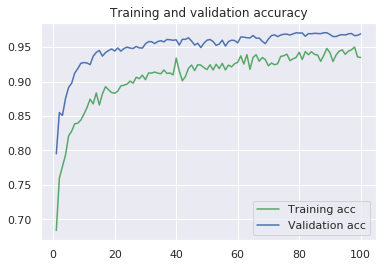

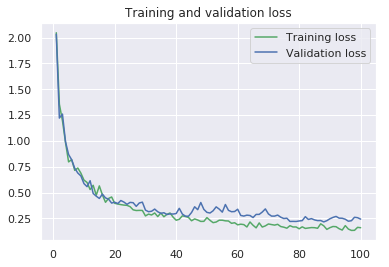

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
model1.load_weights("best_model.hdf5")
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5),
              metrics=['accuracy'])

In [0]:
un_test_img=[]
count=0
for i in os.listdir("../input/test/test/"):
    un_test_img.append(i)
    count+=1
un_test_image=[]
for i in tqdm(range(count)):
    img = image.load_img('../input/test/test/'+un_test_img[i], target_size=(150,150,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    un_test_image.append(img)
un_test_img_array = np.array(un_test_image)

100%|██████████| 4000/4000 [00:06<00:00, 584.12it/s]


In [0]:
len(un_test_img)

4000

In [0]:
output = model1.predict_classes(un_test_img_array)

In [0]:
submission_save = pd.DataFrame()
submission_save['id'] = un_test_img
submission_save['has_cactus'] = output
submission_save.to_csv('submission.csv', header=True, index=False)

In [0]:
results = pd.read_csv('submission.csv')

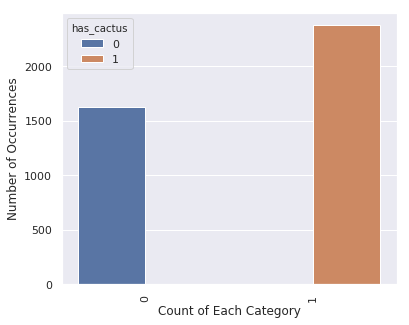

In [0]:
plt.figure(figsize = (6,5))
sns.set(style="darkgrid")
ax = sns.countplot(x = 'has_cactus',hue='has_cactus',data = results)
plt.xticks(rotation='vertical')
plt.xlabel('Count of Each Category', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()